In [12]:
from __future__ import division
from pylab import *


from __future__ import division
import numpy as np

from scipy.special import kn, iv
from scipy.constants import mu_0, c
from pylab import *
from scipy.optimize import newton, fsolve, brentq, fmin, fminbound, minimize_scalar
from scipy.misc import derivative


from __future__ import division
import numpy as np
from scipy.interpolate import interp2d



import sys
from IPython.display import Image  
%matplotlib inline
params = {'legend.fontsize': 24,
          'figure.figsize': (15, 5),
         'axes.labelsize': 24,
         'axes.titlesize': 24,
         'xtick.labelsize':24,
         'ytick.labelsize':24}
plt.rcParams.update(params)







In [13]:
class Inductor(object):
    mu_r_core = 1
    temperature = 25

    def __init__(self, **kwargs):
        self.set_params(**kwargs)

        self.reference_temperature = self.temperature

    def set_params(self, **kwargs):
        for param, value in kwargs.items():
            setattr(self, param, value)

    def tune_parameter(self, input_param_name, output_target_val, input_range=(0, np.inf), output_param_name='Ls_eff', percent_tol=1):
        #TODO: extra parameter to optimize
        '''
        Vary parameter 'input_param_name' so that output 'output_param_name' achieves
        a value of 'output_target_val'.
        '''
        def objective(value):
            setattr(self, input_param_name, value)
            val = (1e9*self.analyze()[output_param_name] - 1e9*output_target_val)**2

            return val

        #new_param_value = fminbound(objective, *param_range, full_output=False)
        new_param_value = minimize_scalar(objective, bounds=input_range, method='bounded').x

        setattr(self, input_param_name, new_param_value)

        error = 100*(self.analyze()[output_param_name] - output_target_val)/output_target_val
        if abs(error) > percent_tol:
            raise Exception('achieved error of %0.2f %% does not meet requirement' % error)

        return new_param_value

    def temperature_expan_factor(self):
        dT = (self.temperature - self.reference_temperature)
        return (1 + self.temp_coeff_expan*dT)

    @property
    def diam_former(self):
        dT = (self.temperature - self.reference_temperature)
        diam_coil = self._diam_former + self._diam_wire
        wire_len_squared = self.len_coil**2 + (np.pi*self.N*diam_coil)**2
        scale_factor = 1 + dT*self.temp_coeff_expan*wire_len_squared/(wire_len_squared - self.len_coil**2)

        #new_diam = self._diam_former + (self.len_coil/np.pi/self.N)**2*self.temp_coeff_expan*dT/(self._diam_former + self._diam_wire)
        new_diam = diam_coil*scale_factor - self.diam_wire
        #new_diam2 = self._diam_former*self.temperature_expan_factor()

        #print 'old diam', self._diam_former
        #print 'new diam', new_diam
        #print 'new diam2', new_diam2

        return new_diam

    @diam_former.setter
    def diam_former(self, value):
        self._diam_former = value

    @property
    def diam_wire(self):
        return self._diam_wire*self.temperature_expan_factor()

    @diam_wire.setter
    def diam_wire(self, value):
        self._diam_wire = value

    @property
    def rho(self):
        temp_factor = (1 + self.temp_coeff_rho*(self.temperature - self.rho_t0))
        return self._rho*temp_factor

    @rho.setter
    def rho(self, value):
        self._rho = value

    def sensitivity(self, input_name, output_name='Ls_eff', delta=0.01, normalize=True):
        old_p  = getattr(self, input_name)
        d_in = delta*old_p

        def func(value):
            setattr(self, input_name, value)

            return self.analyze()[output_name]

        d_out_d_in = derivative(func, old_p, dx=d_in, order=3)
        setattr(self, input_name, old_p)

        if normalize:
            s = (d_out_d_in)*old_p/(self.analyze()[output_name])
        else:
            s = d_out_d_in/(self.analyze()[output_name])

        return s

    @property
    def turn_spacing(self):
        return self.len_coil/self.N - self.diam_wire

    def analyze(self, **new_params):
        if new_params:
            self.set_params(**new_params)

        diam_coil = self.diam_former + self.diam_wire

        '''if self.N*self.diam_wire > self.len_coil:
            raise Exception('physically unrealizable values (reduce self.N*self.diam_wire)')

        if self.diam_wire > diam_coil:
            raise Exception('physically unrealizable values (reduce self.diam_wire)')'''

        pitch = self.len_coil/self.N
        phi = proximity_factor(self.len_coil/diam_coil, self.diam_wire/pitch)
        omega = 2*np.pi*self.f

        # effective diameter of coil
        D_eff = diam_coil - self.diam_wire*(1 - 1/np.sqrt(phi))

        # effective pitch angle
        psi = np.arctan(pitch/(np.pi*D_eff))

        # field non-uniformity correction factor according to Lundin
        if D_eff >= self.len_coil:
            k_L = (1 + 0.383901*np.power(self.len_coil/D_eff, 2) + 0.017108*np.power(self.len_coil/D_eff, 4))\
                 /(1 + 0.258952*np.power(self.len_coil/D_eff, 2))

            k_L = k_L*(np.log(4*D_eff/self.len_coil) - 0.5)
            k_L += 0.093842*np.power(self.len_coil/D_eff, 2) + 0.002029*np.power(self.len_coil/D_eff, 4) - 0.000801*np.power(self.len_coil/D_eff, 6)
            k_L *= (2/np.pi)*(self.len_coil/D_eff)
        else:
            k_L = (1 + 0.383901*np.power(D_eff/self.len_coil, 2) + 0.017108*np.power(D_eff/self.len_coil, 4))\
                /(1 + 0.258952*np.power(D_eff/self.len_coil, 2))
            k_L -= (4/3/np.pi)*(D_eff/self.len_coil)

        # round wire self-inductance correction factor according to Rosa
        k_s = 5/4 - np.log(2*pitch/self.diam_wire)

        # round wire mutual-inductance correction factor according to Grover and Knight
        k_m = -0.16725/self.N + 0.0033/self.N**2
        k_m *= np.log(self.N)
        k_m += 0.337883*(1 - 0.9754/(self.N - 0.0246))

        # effective length of wire
        len_wire_eff = np.hypot(self.N*np.pi*D_eff, self.len_coil)

        # skin depth
        sigma = 1/self.rho
        delta_i = 1/np.sqrt(np.pi*self.f*mu_0*self.mu_r*sigma);

        # effective series AC resistance
        Rs_eff = self.rho*len_wire_eff/(np.pi*(self.diam_wire*delta_i - delta_i**2))*phi
        if self.N > 1:
            Rs_eff *= (self.N - 1)/self.N

        # frequency-independent series inductance
        Ls = self.mu_r_core*mu_0*np.pi*(D_eff*self.N)**2/4/self.len_coil*k_L;
        Ls -= self.mu_r_core*mu_0*D_eff*self.N*(k_s + k_m)/2;

        # numerically find radial wave number
        k0 = omega/c
        a = D_eff/2

        h1 = k0/np.tan(psi)**2 # beta estimate
        h2 = k0

        # FIXME: use brackets
        func = lambda h: helix_dispersion(h, a, psi, k0)
        h = newton(func, (h1 + h2)/2)

        # characteristic impedance
        beta = h2beta(h, k0)
        Z_0 = 60/k0*beta*iv(0, h*a)*kn(0, h*a)

        # effective series inductance at design frequency
        Leffs = Z_0/omega*np.tan(beta*self.len_coil)*k_L
        Leffs -= self.mu_r_core*mu_0*D_eff*self.N*(k_s + k_m)/2

        # effective unloaded quality factor
        Xeffs = omega*Leffs
        Qeff = Xeffs/Rs_eff

        # unloaded quality factor
        Reffp = (Qeff**2 + 1)*Rs_eff
        XLs = omega*Ls;
        RLs = (Reffp - np.sqrt(np.power(Reffp, 2) - 4*np.power(XLs, 2)))/2
        QL = XLs/RLs

        # parallel stray capacitance
        XLp = (np.power(QL, 2) + 1)/np.power(QL, 2)*XLs
        Xeffp = (np.power(Qeff, 2) + 1)/np.power(Qeff, 2)*Xeffs
        XCLp = Xeffp*XLp/(XLp - Xeffp)
        CLp = -1/omega/XCLp

        # find parallel resonant frequency
        # FIXME: Doesn't agree w/ Javascript version!

        def func(w):
            B_res = (pi/2)/self.len_coil
            k0 = w/c
            h = sqrt(B_res**2 - k0**2)

            return helix_dispersion(h, a, psi, k0)**2

        #w_res = fminbound(func, c/len_wire_eff/40, 1*c/len_wire_eff*pi/2)
        w_res = minimize_scalar(func, bounds=(c/len_wire_eff/40, 1*c/len_wire_eff*pi/2), method='bounded').x

        # save all results
        results = {}
        results['char_impedance'] = float(Z_0)
        results['skin_depth'] = float(delta_i)
        results['prop_factor'] = float(beta)
        results['Ls_eff'] = float(Leffs)
        results['Rs_eff'] = float(Rs_eff)
        results['Q_eff'] = float(Qeff)
        results['Ls_equiv'] = float(Ls)
        results['Rs_equiv'] = float(RLs)
        results['Cp_equiv'] = float(CLp)
        results['Q_equiv'] = float(QL)
        results['res_freq'] = float(w_res/2/pi)

        return results

def helix_dispersion(h, a, psi, k0):
    fh = kn(1, h*a)*iv(1, h*a)/kn(0, h*a)/iv(0, h*a) - (h/k0*np.tan(psi))**2

    return fh

def h2beta(h, k0):
    return np.hypot(k0, h)


def main():
    params = dict(N=6, diam_former=3e-3, diam_wire=1e-3, f=10e6, len_coil=8e-3)
    params.update(MATERIALS['Cu, annealed'])

    ind = Inductor(**params)
    results = ind.analyze()

    print(results)


In [14]:
MATERIALS = {}
MATERIALS['Cu, annealed'] = {'rho': 17.241e-9, 'rho_t0': 20, 'temp_coeff_rho': 0.00393, 'mu_r': 0.99999044, 'temp_coeff_expan': 16.6e-6}
MATERIALS['Cu, hard-drawn'] = {'rho': 17.71e-9, 'rho_t0': 20, 'temp_coeff_rho': 0.00382, 'mu_r': 0.99999044, 'temp_coeff_expan': 16.6e-6}
MATERIALS['Ag'] = {'rho': 15.9e-9, 'rho_t0': 20, 'temp_coeff_rho': 0.0038, 'mu_r': 0.9999738, 'temp_coeff_expan': 14.2e-6}
MATERIALS['Al'] = {'rho': 28.24e-9, 'rho_t0': 20, 'temp_coeff_rho': 0.0039, 'mu_r': 1.00002212, 'temp_coeff_expan': 22.2e-6}
MATERIALS['Pt'] = {'rho': 100e-9, 'rho_t0': 20, 'temp_coeff_rho': 0.003, 'mu_r': 1.0002617, 'temp_coeff_expan': 9.0e-6}
MATERIALS['Zn'] = {'rho': 58-9, 'rho_t0': 20, 'temp_coeff_rho': 0.0037, 'mu_r': 0.9999844, 'temp_coeff_expan': 29.7e-6}


INF_D_S = 20

MEDHURST_L_D = np.array([0, 0.2, 0.4, 0.6, 0.8, 1, 2, 4, 6, 8, 10, INF_D_S])
MEDHURST_D_S = np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

# x-axis: length/diam, y-axis: d/s
MEDHURST_MATRIX = np.array([\
        [ 1.   ,  1.   ,  1.   ,  1.   ,  1.   ,  1.   ,  1.   ,  1.   ,  1.   ,  1.   ,  1.   ,  1.   ],
        [ 1.02 ,  1.02 ,  1.03 ,  1.03 ,  1.03 ,  1.03 ,  1.04 ,  1.04 ,  1.04 ,  1.04 ,  1.04 ,  1.05 ],
        [ 1.07 ,  1.08 ,  1.08 ,  1.1  ,  1.1  ,  1.1  ,  1.13 ,  1.15 ,  1.16 ,  1.165,  1.17 ,  1.19 ],
        [ 1.16 ,  1.19 ,  1.21 ,  1.22 ,  1.23 ,  1.24 ,  1.28 ,  1.32 ,  1.34 ,  1.34 ,  1.35 ,  1.395],
        [ 1.2  ,  1.29 ,  1.33 ,  1.38 ,  1.42 ,  1.45 ,  1.5  ,  1.54 ,  1.56 ,  1.57 ,  1.58 ,  1.65 ],
        [ 1.44 ,  1.48 ,  1.54 ,  1.6  ,  1.64 ,  1.67 ,  1.74 ,  1.78 ,  1.8  ,  1.81 ,  1.83 ,  1.93 ],
        [ 1.74 ,  1.77 ,  1.83 ,  1.89 ,  1.92 ,  1.94 ,  1.98 ,  2.01 ,  2.03 ,  2.08 ,  2.1  ,  2.22 ],
        [ 2.12 ,  2.2  ,  2.28 ,  2.38 ,  2.44 ,  2.47 ,  2.32 ,  2.27 ,  2.29 ,  2.34 ,  2.27 ,  2.51 ],
        [ 2.74 ,  2.83 ,  2.97 ,  3.1  ,  3.2  ,  3.17 ,  2.74 ,  2.6  ,  2.6  ,  2.62 ,  2.65 ,  2.815],
        [ 3.73 ,  3.84 ,  3.99 ,  4.11 ,  4.17 ,  4.1  ,  3.36 ,  3.05 ,  2.92 ,  2.9  ,  2.93 ,  3.11 ],
        [ 5.31 ,  5.45 ,  5.65 ,  5.8  ,  5.8  ,  5.55 ,  4.1  ,  3.54 ,  3.31 ,  3.2  ,  3.23 ,  3.41 ]
    ])

proximity_factor = interp2d(MEDHURST_L_D, MEDHURST_D_S, MEDHURST_MATRIX)

__all__ = ['proximity_factor', 'MATERIALS']

In [17]:
def main():
    params = dict(N=6, diam_former=3e-3, diam_wire=1.2e-3, f=100e6, len_coil=5e-3)
    params.update(MATERIALS['Cu, annealed'])

    ind = Inductor(**params)
    #print ind.analyze()

    L_target = 200e-9
    diam_wires = linspace(5, 10)
    fres = []
    qs = []
    lens = []
    temp_sensi = []

    for d in diam_wires:
        print(d)
        ind.N = d

        ind.tune_parameter('len_coil', L_target, param_range=(ind.N*ind.diam_wire, 1))

        result = ind.analyze()
        fres.append(result['res_freq'])
        qs.append(result['Q_eff'])
        lens.append(ind.len_coil)

        s = ind.sensitivity('temperature', normalize=False)
        temp_sensi.append(s)

    figure()
    plot(diam_wires/1e-3, array(fres)/1e6, color='red')
    ylabel('Self-resonant frequency (MHz)', color='red')
    xlabel('Wire diameter (mm)')

    title('L = 80 nH (fixed, coil length varies), Q @ 100 MHz')

    twinx()
    #figure()
    plot(diam_wires/1e-3, qs, color='blue')
    ylabel('Q factor', color='blue')

    figure()
    plot(diam_wires/1e-3, array(temp_sensi)*1e6)
    ylabel('Temperature coefficient (ppm/$\degree$C)')
    xlabel('Wire diameter (mm)')

    show()



In [27]:
def main3():
    params = dict(N=6, diam_former=3e-3, diam_wire=1e-3, f=10e6, len_coil=8e-3)
    params.update(MATERIALS['Cu, annealed'])

    ind = Inductor(**params)
    print(ind.analyze())

    print( 'current Ls', ind.analyze()['Ls_eff'])
    print( 'current Q', ind.analyze()['Q_eff'])

    #return

    #print 'param tunes to', ind.tune_parameter('len_coil', 50e-9, param_range=(0, 50e-3))

    print( 'Q_eff sensi', 100*ind.sensitivity('N', 'Q_eff'))
    print( 'Ls_eff sensi', 100*ind.sensitivity('N', 'Ls_eff'))

    input_values = linspace(1, 20, 50)*1e6
    qs = zeros(len(input_values))
    sensi = zeros(len(input_values))
    coil_len = zeros(len(input_values))
    Ls = zeros(len(input_values))

    for i, inp in enumerate(input_values):
        ind.f = inp
        '''try:
            ind.tune_parameter('len_coil', 100e-9, param_range=(ind.N*ind.diam_wire, 100e-3))
        except:
            continue'''

        results = ind.analyze()
        qs[i] = results['Q_eff']
        Ls[i] = results['Ls_eff']

        sensi[i] = ind.sensitivity('temperature', 'Ls_eff', normalize=False)
        coil_len[i] = ind.turn_spacing

    figure()
    plot(input_values, qs)
    title('Q')

    figure()
    plot(input_values, 1e6*sensi)
    title('Sensitivity')

    figure()
    plot(input_values, coil_len)
    title('coil spacing')

    figure()
    plot(input_values, Ls/1e-9)
    title('induct')

    show()






In [28]:

def main2():
    params = dict(N=4, diam_former=5e-3, diam_wire=1.2e-3, f=100e6, len_coil=51e-3)
    params.update(MATERIALS['Cu, annealed'])

    L_desired = 50e-9

    ind = Inductor(**params)

    print( 'Initial length = %0.3f mm -> inductance = %0.3f nH' % (ind.len_coil/1e-3, ind.analyze()['Ls_eff']/1e-9))
    #ind.tune_parameter('len_coil', L_desired, input_range=(ind.N*ind.diam_wire, 1))
    ind.tune_parameter('len_coil', L_desired, input_range=(1e-3, 1))

    print( ind.N*ind.diam_wire)


    print( '> Tuned length = %0.3f mm -> inductance = %0.3f nH' % (ind.len_coil/1e-3, ind.analyze()['Ls_eff']/1e-9))
    print( ind.analyze())

    lens = linspace(ind.N*ind.diam_wire, 100e-3, 100)

    inds = [ind.analyze(len_coil=el)['Ls_eff'] for el in lens]
    qs = [ind.analyze(len_coil=el)['Q_eff'] for el in lens]

    if 0:
        inds = []

        for el in lens:
            ind.len_coil = el
            inds.append(ind.sensitivity('len_coil'))

    figure()
    plot(lens/1e-3, inds)

    figure()
    plot(lens/1e-3, qs)

    figure()
    plot(inds, qs)

    show()

{'Ls_equiv': 4.18213766576639e-08, 'Rs_equiv': 0.0260142920022588, 'res_freq': 1088325440.0625987, 'Q_eff': 82.14705604747247, 'skin_depth': 2.1102261245635593e-05, 'Rs_eff': 0.03933132499704669, 'Q_equiv': 101.01042124023245, 'Cp_equiv': 1.1309733366263994e-09, 'char_impedance': 1062.8882724816337, 'Ls_eff': 5.142220706528976e-08, 'prop_factor': 0.5173362883660613}
current Ls 5.142220706528976e-08
current Q 82.14705604747247
Q_eff sensi -104.128538329
Ls_eff sensi 128.414680238


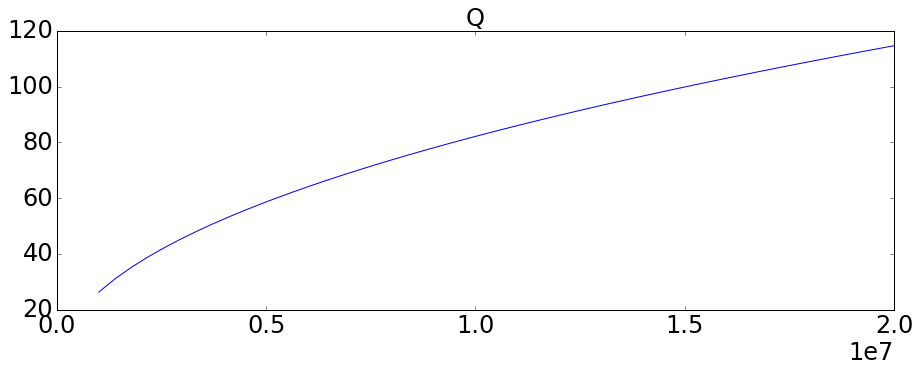

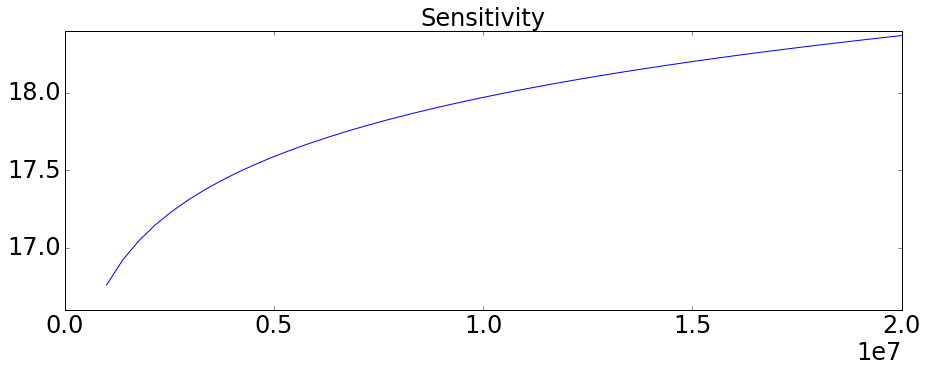

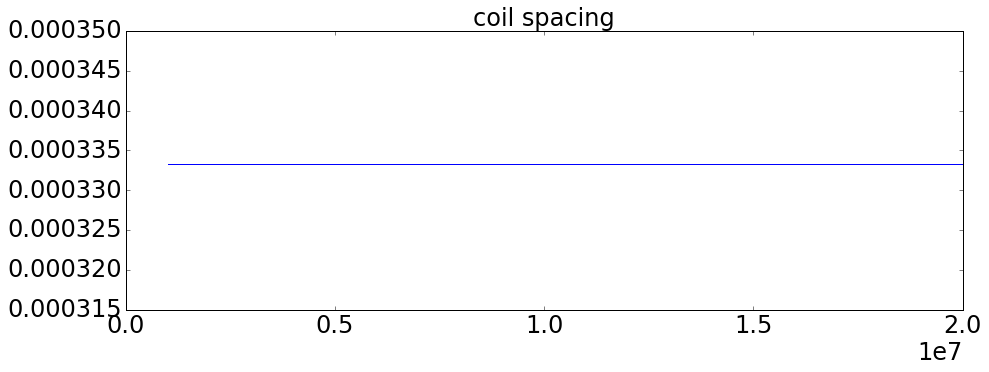

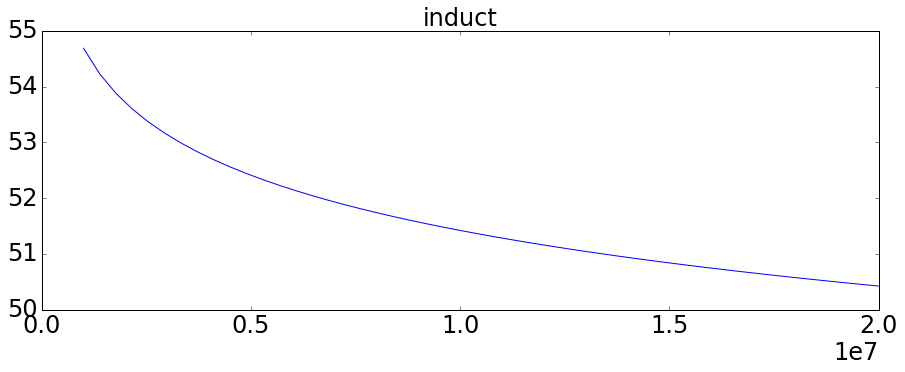

In [29]:
main3()